In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import yaml
import pickle
from utils import *
from helpers import *

import pdb
from tqdm import tqdm

from proSVD import proSVD

In [90]:
class DataManager:
    def __init__(self):
        self.data = {
            'Q': [],
            'frame': []
        }
    
    def _print_key_error(self, key):
        print(f"Key '{key}' does not exist in the data manager.")

    def add_nan(self, key, shape):
        data_ = self.data[key]
        pop_count = 0
        while len(data_) > 0 and data_[-1] is None:
            data_.pop()
            pop_count += 1
        while pop_count > 0:
            data_.append(np.full(shape, np.nan))
            pop_count -= 1

    def add(self, key, value):
        if key in self.data:
            if value is not None:
                self.add_nan(key, value.shape)
            self.data[key].append(value)
        else:
            self._print_key_error(key)

    def to_numpy(self):
        for key in self.data:
            data_ = self.data[key]
            if len(data_) == 0 or data_[0] is None:
                self.data[key] = None
                return
            self.add_nan(key, data_[0].shape)
            self.data[key] = np.array(data_)

    def remove(self, key):
        if key in self.data:
            del self.data[key]
        else:
            self._print_key_error(key)

    def get(self, key):
        if key in self.data:
            return self.data[key]
        else:
            self._print_key_error(key)
            return None

In [133]:
import cv2
import numpy as np

# Open the video file
video_dir = '/home/sachinks/Code/stim_behavior/data'
video_filename = 'zebrafish'
cap = cv2.VideoCapture(f'{video_dir}/{video_filename}.mp4')

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define temporal filter parameters
sigma_t = 0.5  # Sigma for the temporal Gaussian blur

# Define the output video file
output_video_path = f'{video_dir}/{video_filename}_smoothed.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Create Gaussian kernel for the temporal dimension
num_frames_in_kernel = 2 * int(2 * sigma_t) + 1
print("Kernel Size:", num_frames_in_kernel)
temporal_kernel = cv2.getGaussianKernel(num_frames_in_kernel, sigma_t)

# Normalize the kernel to sum up to 1
temporal_kernel /= temporal_kernel.sum()

# Initialize buffer to store frames for temporal filtering
frame_buffer = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_buffer.append(frame)
    
    # Keep the buffer size limited to the size of the temporal kernel
    if len(frame_buffer) > num_frames_in_kernel:
        frame_buffer.pop(0)
    
    # Apply Gaussian blur along the time dimension
    if len(frame_buffer) >= num_frames_in_kernel:
        smoothed_frame = np.zeros_like(frame_buffer[0], dtype=np.float32)
        for i, frame in enumerate(frame_buffer):
            smoothed_frame += frame * temporal_kernel[i]
        smoothed_frame = smoothed_frame.astype(np.uint8)
        out.write(smoothed_frame)
    
        # cv2.imshow('Processed Video', smoothed_frame)
    
    # Exit when 'q' is pressed
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Release video objects and close the window
cap.release()
out.release()
# cv2.destroyAllWindows()


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Kernel Size: 3


In [134]:
video_dir = '/home/sachinks/Code/stim_behavior/data'
video_filename = 'zebrafish_smoothed'

PROSVD_K = 4 # no. of dims to reduce to
init_frame_prosvd = 20 # No of initial frames used to initialize proSVD

try:
    video = load_video(video_dir, video_filename)
    fps = int(video.get(cv2.CAP_PROP_FPS))
    print(f"Frames Per Second (fps): {fps}")
except:
    print("...")
    pass

index = -1
frames = []  # for proSVD initialization
dm = DataManager()

while video.isOpened():
    index += 1
    ret, frame = video.read()
    if not ret:
        break

    frame = rgb_to_grayscale(frame)
    frame = downsample_image(frame)
    frame = frame.flatten()

    if index < init_frame_prosvd:
        frames.append(frame)
        continue

    if index == init_frame_prosvd:
        frames = np.array(frames).T
        pro = proSVD(k=PROSVD_K, w_len=1,history=0, decay_alpha=1, trueSVD=True)
        pro.initialize(frames)
        del frames


    pro.preupdate()
    pro.updateSVD(frame[:, None])
    pro.postupdate()

    dm.add('Q', pro.Q)
    dm.add('frame', frame)

video.release()
dm.to_numpy()

Frames Per Second (fps): 10


In [146]:
tx = np.arange(init_frame_prosvd, index, 1)/fps

Q_full = dm.get('Q')
Q_diff = np.diff(Q_full, axis=0)
Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

frames = dm.get('frame')
pro_coordi = np.zeros((Q_full.shape[0], 4))
for i in range(len(pro_coordi)):
    pro_coordi[i] = frames[i] @ Q_full[i]


print(frames.shape)
print(Q_full.shape)
print(pro_coordi.shape)

(339, 40000)
(339, 40000, 4)
(339, 4)


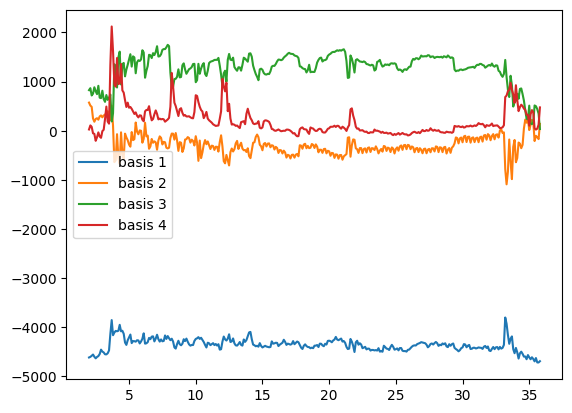

In [136]:
for i in range(PROSVD_K):
    plt.plot(tx, pro_coordi[:, i], label=f'basis {i+1}')
plt.legend()
plt.show()

0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330


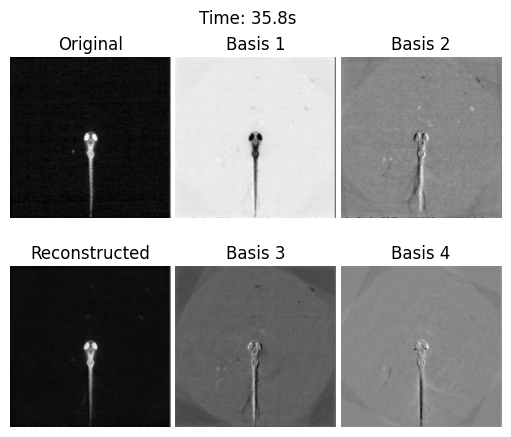

In [145]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

frames = dm.get('frame').reshape(-1, 200, 200)

# List of NumPy arrays representing images
images = [Q_full[i, :, :].reshape(200, 200, -1) for i in range(Q_full.shape[0])]
# images = images[:30]


# Create a figure and axis objects
num_rows, num_cols = 2, 3
fig, axs = plt.subplots(num_rows, num_cols)

# Function to update the plot with each frame
def update(frame):
    if frame % 10 == 0:
        print(frame)
    for i in range(num_rows):
        for j in range(num_cols-1):
            k = j+2*i
            axs[i, j+1].clear()
            axs[i, j+1].imshow(images[frame][..., k], cmap='gray')
            axs[i, j+1].set_title(f"Basis {k + 1}")
            axs[i, j+1].axis('off')
    axs[0, 0].axis('off')
    axs[0, 0].imshow(frames[frame], cmap='gray')
    axs[0, 0].set_title(f"Original")
    
    axs[1, 0].axis('off')
    axs[1, 0].imshow(images[frame] @ pro_coordi[frame], cmap='gray')
    axs[1, 0].set_title(f"Reconstructed")
    fig.subplots_adjust(hspace=0.3, wspace=0)
    fig.suptitle(f"Time: {tx[frame]}s")

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(images), interval=200)

# Save the animation as a GIF
output_gif_path = f'output_smoothed.gif'
ani.save(output_gif_path, writer='pillow', fps=10)

# Show the plot
plt.show()

In [199]:
def custom_comparator(arr1, arr2):
    arr2 += 1e-6
    res = arr1/arr2
    return res > 1.5
    
local_maxima_indices = argrelextrema(Q_norm_diff[:, 3], custom_comparator, order=2)
tx[local_maxima_indices]

array([ 3.3,  4.1,  4.4,  8.2,  8.7, 10.6, 12. , 34. , 35. ])

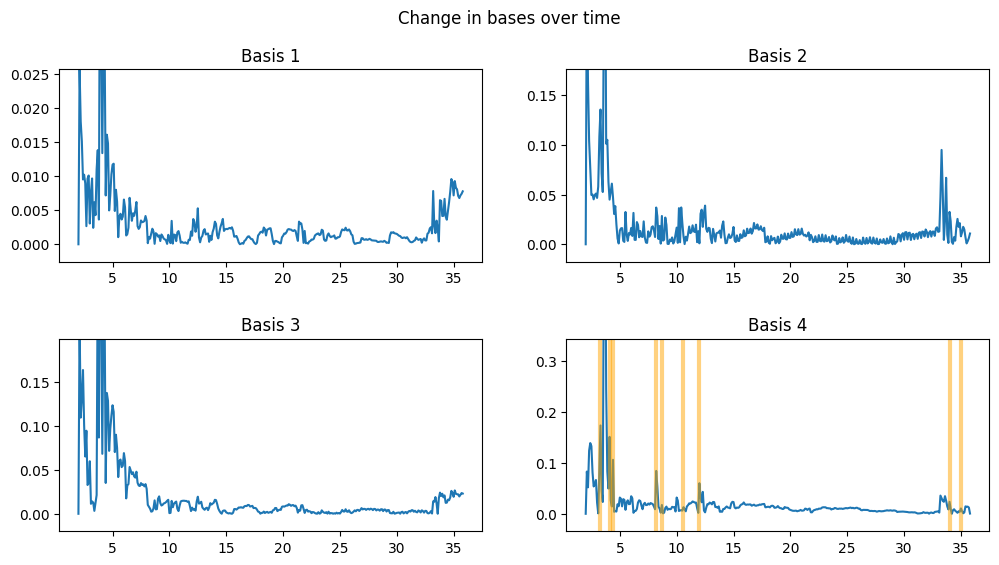

In [213]:
num_rows, num_cols = 2, 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(num_rows):
    for j in range(num_cols):
        k = j+2*i
        axs[i, j].plot(tx, Q_norm_diff[:, k])
        axs[i, j].set_title(f"Basis {k + 1}")
        max_val = Q_norm_diff[:, k].max()/2
        axs[i, j].set_ylim(-0.1*max_val, max_val)
        # axs[i, j].axis('off')

for x in tx[local_maxima_indices]:
    axs[1, 1].axvline(x=x, color='orange', linewidth=3, alpha=0.5)

fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Change in bases over time")
plt.show()

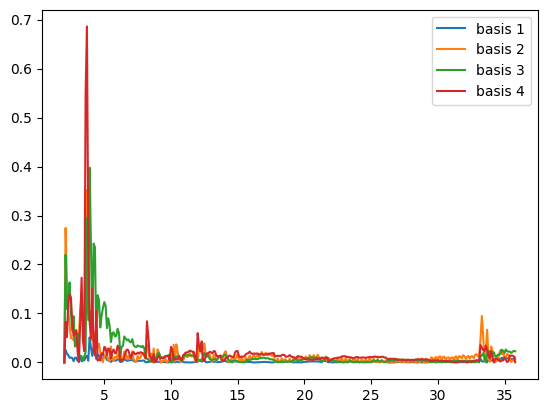

In [148]:
for i in range(PROSVD_K):
    plt.plot(tx[:], Q_norm_diff[:, i], label=f'basis {i+1}')
plt.legend()
plt.show()

In [ ]:
## Points of interest
4, 8, 10, 12, 33

In [187]:
local_maxima_indices = argrelextrema(Q_norm_diff[:, k], np.greater, order=5)
tx[local_maxima_indices]

array([ 2.4,  3.7,  5. ,  6. ,  6.7,  8.2, 10. , 11.4, 12. , 13.2, 14.9,
       15.9, 17.7, 18.4, 19.5, 21.7, 22.9, 23.9, 25.3, 28.5, 31.7, 33.2,
       35.4])

array([ 3.3,  4.1,  4.4,  8.2,  8.7, 10.6, 12. , 34. , 35. ])

Local Maxima Indices: (array([4, 7]),)
Local Maxima Values: [ 8. 10.]


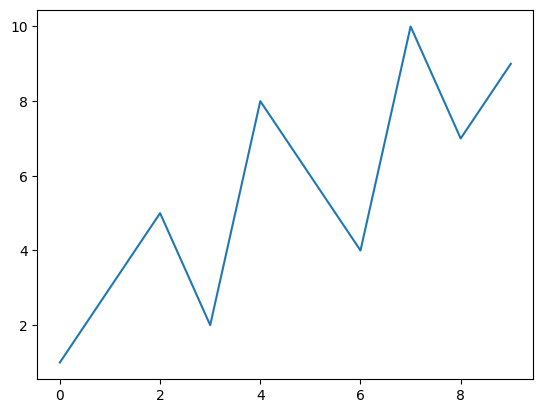

In [177]:
import numpy as np
from scipy.signal import argrelextrema

# Sample time series data
time_series = np.array([1, 3, 5, 2, 8, 6, 4, 10, 7, 9], dtype=float)

# Find local maxima indices
local_maxima_indices = argrelextrema(time_series, np.greater, order=2)

# Get local maxima values and their indices
local_maxima_values = time_series[local_maxima_indices]

print("Local Maxima Indices:", local_maxima_indices)
print("Local Maxima Values:", local_maxima_values)

plt.plot(time_series)
